In [84]:
import os
import pandas as pd
import numpy as np
import random
import datetime as dt
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split

In [85]:
cwd = os.path.abspath('') + '/'
random.seed(1)

In [86]:
def GARCH(y, start, end, split_date):
    """ General Autoregressive Conditional Heteroskedasticity Model 
    p -> Lag length
    q -> Order of ARCH terms
    y -> Timeseries Dataframe
    """
    model = arch_model(y, vol='Garch', p=1, o=0, q=1, dist='StudentsT', rescale=False)
    results = model.fit(last_obs=split_date)
    print(results.summary())

    sims = results.forecast(horizon=8, start=split_date)
    
    sims.variance[split_date:].plot()
    plt.title("Variance Forecast from " + split_date.strftime("%m/%d/%Y") + " to " + end.strftime("%m/%d/%Y") + " (m/d/y)")
    plt.ylabel("Variance [%]")
    

Load the data from the 4th of January, 1950 to the 1st of June, 2018 and convert it into daily returns.

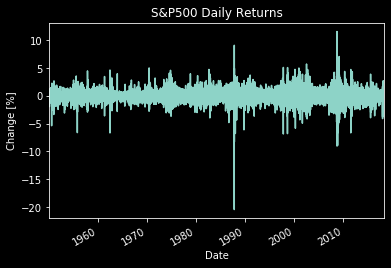

In [87]:
start = dt.datetime(1950, 1, 4)
end = dt.datetime(2018, 6, 1)

data = web.get_data_yahoo('^GSPC', start=start, end=end)

r_t = 100*data['Close'].pct_change().dropna()
plt.title("S&P500 Daily Returns")
plt.ylabel("Change [%]")
r_t.plot()


Run GARCH on the data and plot the results

Iteration:      1,   Func. Count:      7,   Neg. LLF: 17644.170571314113
Iteration:      2,   Func. Count:     20,   Neg. LLF: 17633.518859727705
Iteration:      3,   Func. Count:     28,   Neg. LLF: 17623.374491287337
Iteration:      4,   Func. Count:     38,   Neg. LLF: 17622.26381268903
Iteration:      5,   Func. Count:     46,   Neg. LLF: 17591.337203480463
Iteration:      6,   Func. Count:     54,   Neg. LLF: 17588.60756835413
Iteration:      7,   Func. Count:     62,   Neg. LLF: 17585.491727170767
Iteration:      8,   Func. Count:     71,   Neg. LLF: 17584.85115272994
Iteration:      9,   Func. Count:     79,   Neg. LLF: 17582.325831575166
Iteration:     10,   Func. Count:     87,   Neg. LLF: 17581.8377069433
Iteration:     11,   Func. Count:     95,   Neg. LLF: 17581.577925818747
Iteration:     12,   Func. Count:    103,   Neg. LLF: 17581.40302397536
Iteration:     13,   Func. Count:    110,   Neg. LLF: 17581.400180692537
Iteration:     14,   Func. Count:    117,   Neg. LLF: 175

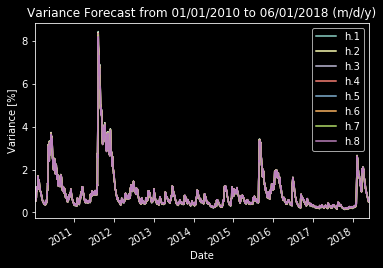

In [88]:

split_date = dt.datetime(2010, 1, 1)

GARCH(r_t, start, end, split_date)
